In [4]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import numpy as np
import pandas as pd
import polars as pl
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [5]:
drive.mount('/content/drive')
# df = pl.read_csv("/content/drive/MyDrive/CSC 581 Project/Copy of tmBirdWeather.csv")
df = pl.read_csv("/content/drive/MyDrive/CSC 581 Project/tmBirdWeather.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df.head()

h3_index,MEAN_LATITUDE,MEAN_LONGITUDE,OBSERVATION DATE,OBSERVATION COUNT,OBSERVATION COUNT BINNED,temperature_2m_max,temperature_2m_min,temperature_2m_mean,rain_sum,snowfall_sum,wind_gusts_10m_max
str,f64,f64,str,f64,i64,f64,f64,f64,f64,f64,f64
"""83128dfffffffff""",52.981529,-122.489218,"""2023-01-19""",2.0,0,1.6025,-4.1975,-2.030833,0.0,1.19,31.319998
"""8344a9fffffffff""",28.575442,-81.354389,"""2023-11-09""",2.0,0,26.291,19.490999,21.9785,0.7,0.0,36.0
"""8328c6fffffffff""",46.861114,-123.923394,"""2024-04-25""",4.0,0,11.3055,5.8555,8.713833,6.3,0.0,45.0
"""852aa84ffffffff""",38.918499,-77.105884,"""2023-03-30""",4.0,0,21.097,5.497,13.474084,0.0,0.0,38.16
"""842b9b1ffffffff""",43.211068,-79.226351,"""2022-06-23""",2.0,0,25.8085,17.0585,21.041836,0.0,0.0,36.0


In [7]:
df = df.with_columns(
    pl.col("OBSERVATION DATE").str.to_date("%Y-%m-%d").alias("OBSERVATION DATE")
)

In [8]:
df = df.with_columns(
    pl.when(pl.col("OBSERVATION COUNT") < 10).then(0)
     .when(pl.col("OBSERVATION COUNT") < 100).then(1)
     .otherwise(2).alias("OBSERVATION COUNT BINNED")
)

In [9]:
df = df.with_columns([
    pl.col("OBSERVATION DATE").dt.year().alias("YEAR"),
    pl.col("OBSERVATION DATE").dt.month().alias("MONTH"),
    pl.col("OBSERVATION DATE").dt.ordinal_day().alias("DAY OF YEAR")
])

In [10]:
df = df.with_columns(
    pl.when(pl.col("MONTH").is_in([12, 1, 2])).then(1)
     .when(pl.col("MONTH").is_in([3, 4, 5])).then(2)
     .when(pl.col("MONTH").is_in([6, 7, 8])).then(3)
     .when(pl.col("MONTH").is_in([9, 10, 11])).then(4)
     .alias("SEASON")
)

In [11]:
df_pd = df.to_pandas()

In [12]:
le = LabelEncoder()
df_pd["h3_index_encoded"] = le.fit_transform(df_pd["h3_index"])

In [13]:
features = [
    "MEAN_LATITUDE", "MEAN_LONGITUDE", "temperature_2m_max",
    "temperature_2m_min", "temperature_2m_mean", "rain_sum",
    "snowfall_sum", "wind_gusts_10m_max", "YEAR", "MONTH",
    "DAY OF YEAR", "SEASON", "h3_index_encoded"
]

In [14]:
X = df_pd[features]
y = df_pd["OBSERVATION COUNT BINNED"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [15]:
from collections import Counter

#compute weights for each class
class_counts = Counter(y_train)
total = sum(class_counts.values())
weights = {cls: total/count for cls, count in class_counts.items()}

sample_weights = y_train.map(weights)

In [16]:
# model = xgb.XGBClassifier(
#     objective="multi:softmax",
#     num_class=3,
#     eval_metric="mlogloss",
#     use_label_encoder=False,
#     random_state=42
# )

# model.fit(X_train, y_train)

model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42
)

model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1920
           1       0.21      0.14      0.17        78
           2       0.00      0.00      0.00         2

    accuracy                           0.94      2000
   macro avg       0.39      0.37      0.38      2000
weighted avg       0.93      0.94      0.94      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
print(model.get_booster().num_boosted_rounds())


100


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

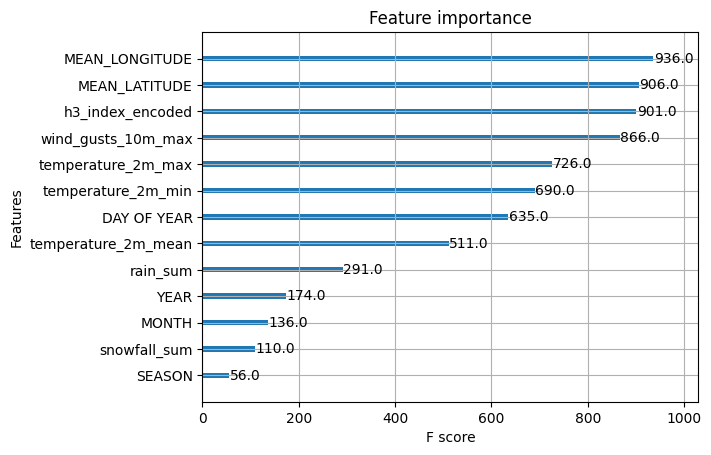

In [18]:
xgb.plot_importance(model)


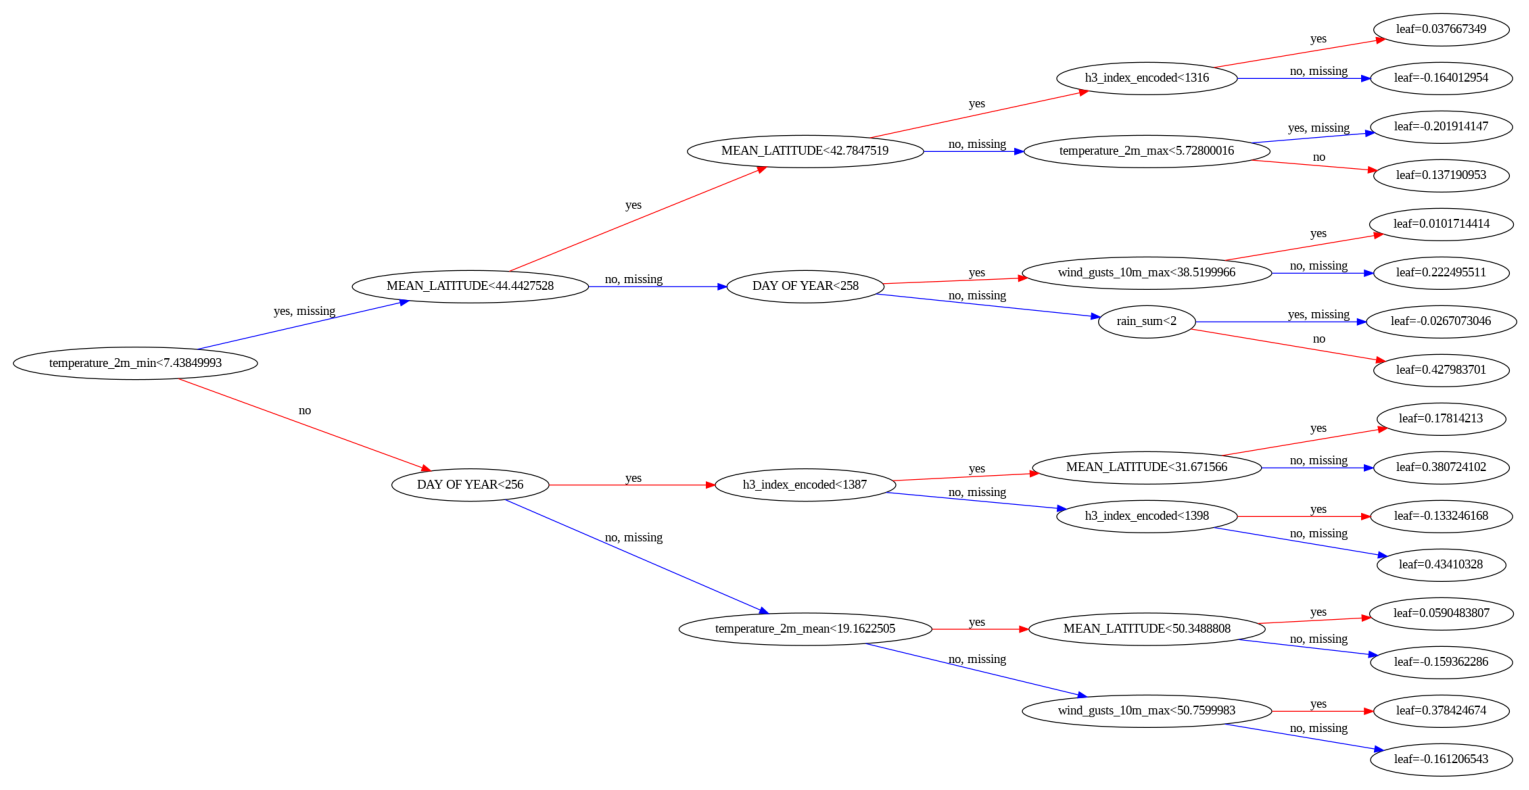

In [19]:
model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    max_depth=4,   # Try 3 instead of the default 6
    eval_metric="mlogloss",
    random_state=42
)

model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = model.predict(X_test)
# Plot the first tree in the model
xgb.plot_tree(model, num_trees=0, rankdir='LR', fmap='')

# Optional: Adjust figure size
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()


In [20]:
y_pred = model.predict(X_test)

predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(predictions_df.head())


      Actual  Predicted
1104       0          0
3861       0          1
2608       0          0
7101       0          0
4595       0          0


In [21]:
from collections import Counter

class_counts = Counter(y_train)
print("Class distribution in y_train:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")


Class distribution in y_train:
Class 0: 7682 samples
Class 1: 312 samples
Class 2: 6 samples


In [22]:
from collections import Counter

pred_counts = Counter(y_pred)
print("Predicted class distribution:")
for label, count in pred_counts.items():
    print(f"Class {label}: {count} samples")


Predicted class distribution:
Class 0: 1802 samples
Class 1: 198 samples


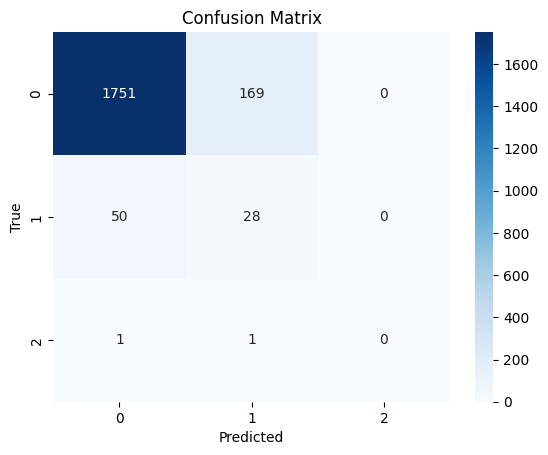

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [24]:
import numpy as np

print("Sample weights per class:")
for cls, w in weights.items():
    print(f"Class {cls}: weight = {w:.2f}")


Sample weights per class:
Class 0: weight = 1.04
Class 1: weight = 25.64
Class 2: weight = 1333.33


In [25]:
import pandas as pd

weight_df = pd.DataFrame({'label': y_train, 'weight': sample_weights})
print(weight_df.groupby('label')['weight'].describe())


        count         mean           std          min          25%  \
label                                                                
0      7682.0     1.041395  3.042209e-14     1.041395     1.041395   
1       312.0    25.641026  6.049315e-14    25.641026    25.641026   
2         6.0  1333.333333  0.000000e+00  1333.333333  1333.333333   

               50%          75%          max  
label                                         
0         1.041395     1.041395     1.041395  
1        25.641026    25.641026    25.641026  
2      1333.333333  1333.333333  1333.333333  


In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
import xgboost as xgb
from sklearn.metrics import classification_report

features = [
    "MEAN_LATITUDE", "MEAN_LONGITUDE", "temperature_2m_max",
    "temperature_2m_min", "temperature_2m_mean", "rain_sum",
    "snowfall_sum", "wind_gusts_10m_max", "YEAR", "MONTH",
    "DAY OF YEAR", "SEASON", "h3_index_encoded"
]

X = df_pd[features]
y = df_pd["OBSERVATION COUNT BINNED"]

df_cleaned = df_pd.dropna(subset=features + ["OBSERVATION COUNT BINNED"])

X_cleaned = df_cleaned[features]
y_cleaned = df_cleaned["OBSERVATION COUNT BINNED"]

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, stratify=y_cleaned, test_size=0.2, random_state=42)

print(f"Original class distribution: {Counter(y_train)}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled class distribution: {Counter(y_train_resampled)}")

model = xgb.XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss", random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


Original class distribution: Counter({0: 6623, 1: 267, 2: 6})
Resampled class distribution: Counter({0: 6623, 1: 6623, 2: 6623})
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1656
           1       0.30      0.19      0.24        67
           2       0.00      0.00      0.00         1

    accuracy                           0.95      1724
   macro avg       0.42      0.39      0.40      1724
weighted avg       0.94      0.95      0.94      1724



In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import xgboost as xgb
from sklearn.metrics import classification_report

# Assuming df_pd is your DataFrame with features and target 'OBSERVATION COUNT BINNED'
features = [
    "MEAN_LATITUDE", "MEAN_LONGITUDE", "temperature_2m_max",
    "temperature_2m_min", "temperature_2m_mean", "rain_sum",
    "snowfall_sum", "wind_gusts_10m_max", "YEAR", "MONTH",
    "DAY OF YEAR", "SEASON", "h3_index_encoded"
]

X = df_pd[features]
y = df_pd["OBSERVATION COUNT BINNED"]

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Identify the minority classes (Class 1 and Class 2)
minority_classes = y_train.value_counts()[y_train.value_counts() < 100]  # Assuming class counts < 100 are minority classes

# Define a function to add random perturbations to the data
def add_random_perturbations(X, y, minority_classes, perturbation_scale=0.05):
    """
    Add random perturbations (noise) to the features of the minority class samples.
    """
    X_perturbed = X.copy()
    y_perturbed = y.copy()

    for label in minority_classes:
        # Get the indices of the minority class samples
        minority_indices = y[y == label].index

        # Perturb each sample by adding small random noise (scaled by perturbation_scale)
        for idx in minority_indices:
            # Generate random noise (Gaussian noise) with mean=0 and std=perturbation_scale
            noise = np.random.randn(len(X.iloc[idx])) * perturbation_scale  # Adding Gaussian noise
            X_perturbed.iloc[idx] = X.iloc[idx] + noise

    return X_perturbed, y_perturbed

# Apply perturbations to the training data
X_train_perturbed, y_train_perturbed = add_random_perturbations(X_train, y_train, minority_classes=[1, 2])

# Check class distribution after perturbation
print(f"Class distribution after perturbation: {Counter(y_train_perturbed)}")

# Train an XGBoost model on the perturbed data
model = xgb.XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss", random_state=42)
model.fit(X_train_perturbed, y_train_perturbed)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


IndexError: single positional indexer is out-of-bounds

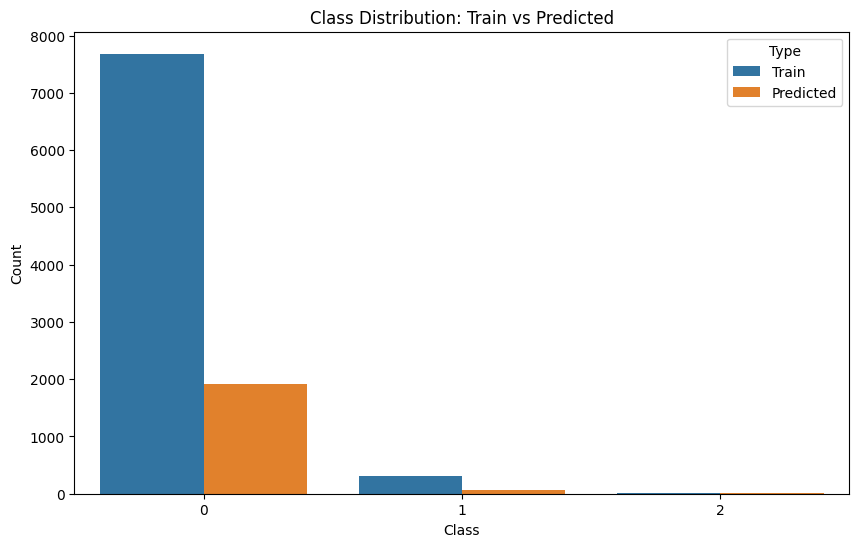

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt


train_class_counts = Counter(y_train)


y_pred = model.predict(X_test)
pred_class_counts = Counter(y_pred)

train_dist = pd.DataFrame(list(train_class_counts.items()), columns=['Class', 'Count'])
train_dist['Type'] = 'Train'

pred_dist = pd.DataFrame(list(pred_class_counts.items()), columns=['Class', 'Count'])
pred_dist['Type'] = 'Predicted'

class_dist = pd.concat([train_dist, pred_dist])

plt.figure(figsize=(10, 6))
sns.barplot(data=class_dist, x='Class', y='Count', hue='Type')
plt.title('Class Distribution: Train vs Predicted')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


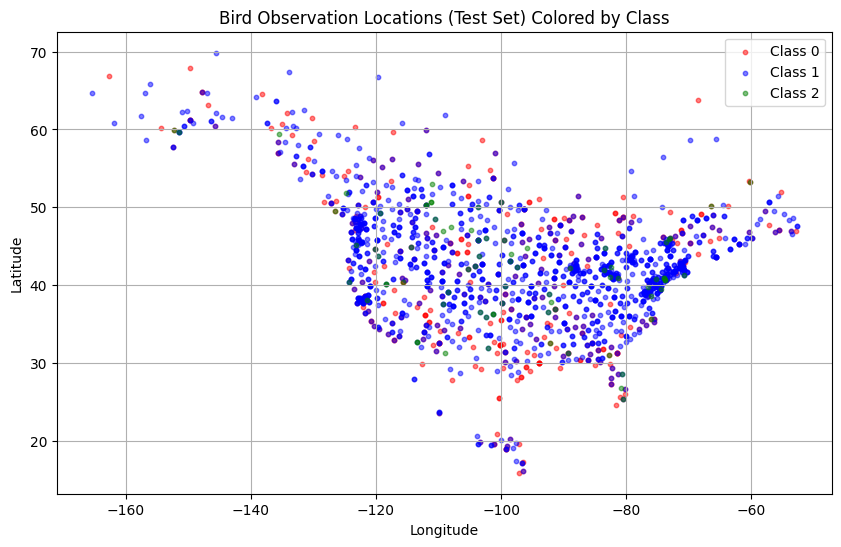

In [ ]:
# SAMPLE INTERFACE

# 0 - low
# 1 - med
# 2 - high


import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

colors = ['red', 'blue', 'green']  # assign colors for classes 0, 1, 2

for class_label in range(len(colors)):
    class_indices = np.where(y_test == class_label)
    plt.scatter(X_test.iloc[class_indices]['MEAN_LONGITUDE'],
                X_test.iloc[class_indices]['MEAN_LATITUDE'],
                c=colors[class_label],
                s=10, alpha=0.5, label=f'Class {class_label}')

plt.title('Bird Observation Locations (Test Set) Colored by Class')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
## testing a random data point
data_values = [
    44.7128,  # MEAN_LATITUDE
    -74.0060, # MEAN_LONGITUDE
    25,       # temperature_2m_max
    15,       # temperature_2m_min
    20,       # temperature_2m_mean
    0.8,      # rain_sum
    0.0,      # snowfall_sum
    25,       # wind_gusts_10m_max
    2023,     # YEAR
    11,       # MONTH
    315,      # DAY_OF_YEAR
    4,        # SEASON (assuming this is correctly encoded as per your model's training)
    100       # h3_index_encoded (ensure this encoding matches training)
]

new_data_point = np.array([data_values])

predictions = model.predict(new_data_point)
print("Predictions:", predictions)


Predictions: [1]


In [ ]:
print(model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)


# Map Display with future predictions

In [ ]:
## imports for display

!pip install openmeteo_requests requests_cache retry_requests -q
!pip install tqdm ipywidgets -q
!pip install geopandas -q

import openmeteo_requests
import requests_cache
from retry_requests import retry
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display, clear_output
import time
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import concurrent.futures

import geopandas as gpd
from matplotlib.colors import ListedColormap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.4 MB/s eta 0:00:00


In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 1  # winter
    elif month in [3, 4, 5]:
        return 2  # spring
    elif month in [6, 7, 8]:
        return 3  # summer
    else:
        return 4  # fall

def get_day_of_year(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    return date_obj.timetuple().tm_yday

# create the forecast API client
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

def fetch_archive_weather_batch(locations, date):
    if not locations:
        return {}

    # prepare the batch request
    url = "https://archive-api.open-meteo.com/v1/archive"
    results = {}

    # process locations in batches of 10
    batch_size = 10
    for i in range(0, len(locations), batch_size):
        batch_locations = locations[i:i+batch_size]
        batch_requests = []

        for location in batch_locations:
            lat, lon = location
            params = {
                "latitude": lat,
                "longitude": lon,
                "start_date": date,
                "end_date": date,
                "daily": [
                    "temperature_2m_max",
                    "temperature_2m_min",
                    "temperature_2m_mean",
                    "rain_sum",
                    "snowfall_sum",
                    "wind_gusts_10m_max"
                ],
                "timezone": "auto"
            }
            batch_requests.append(params)

        try:
            # use concurrent requests for this batch
            with concurrent.futures.ThreadPoolExecutor(max_workers=batch_size) as executor:
                futures = [executor.submit(requests.get, url, params=params) for params in batch_requests]
                responses = [future.result() for future in futures]

            # process responses
            for j, response in enumerate(responses):
                lat, lon = batch_locations[j]
                location_key = (lat, lon)

                if response.status_code != 200:
                    print(f"Error: API request failed for {lat}, {lon} with status code {response.status_code}")
                    continue

                data = response.json()

                if "daily" not in data:
                    print(f"No daily data available for {lat}, {lon} on {date}")
                    continue

                # extract the daily data and convert all values to float
                result = {}
                for key in ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean",
                           "rain_sum", "snowfall_sum", "wind_gusts_10m_max"]:
                    if key in data["daily"]:
                        value = data["daily"][key][0]
                        result[key] = float(value) if value is not None else 0.0
                    else:
                        result[key] = 0.0

                results[location_key] = result

            time.sleep(0.2)

        except Exception as e:
            print(f"Error fetching batch weather data: {e}")

    return results

def fetch_forecast_weather_batch(locations, date):
    if not locations:
        return {}

    results = {}
    url = "https://api.open-meteo.com/v1/forecast"

    # process locations in batches
    batch_size = 10
    for i in range(0, len(locations), batch_size):
        batch_locations = locations[i:i+batch_size]

        try:
            # make individual requests instead of batch requests
            for lat, lon in batch_locations:
                params = {
                    "latitude": lat,
                    "longitude": lon,
                    "daily": [
                        "temperature_2m_max",
                        "temperature_2m_min",
                        "temperature_2m_mean",
                        "rain_sum",
                        "snowfall_sum",
                        "wind_speed_10m_max"
                    ],
                    "timezone": "auto",
                    "forecast_days": 16
                }

                # call the API for each location individually
                responses = openmeteo.weather_api(url, params=params)
                response = responses[0]

                # get the daily data from the response
                daily = response.Daily()

                # get the timestamps
                daily_time = pd.date_range(
                    start=pd.to_datetime(daily.Time(), unit="s"),
                    periods=len(daily.Variables(0).ValuesAsNumpy()),
                    freq="24h"
                )

                # convert dates to string format for comparison
                date_strings = [d.strftime('%Y-%m-%d') for d in daily_time]

                if date not in date_strings:
                    print(f"Date {date} not found in forecast for {lat}, {lon}. Available dates: {date_strings[:3]}...")
                    continue

                # find the index of our target date
                date_idx = date_strings.index(date)

                # get all the variables we need
                result = {}

                # map the variable positions based on the order we requested them
                variable_names = ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean",
                                "rain_sum", "snowfall_sum", "wind_speed_10m_max"]

                for k, var_name in enumerate(variable_names):
                    # get the values for this variable
                    values = daily.Variables(k).ValuesAsNumpy()

                    # store the value for our date (use wind_speed for wind_gusts)
                    actual_key = "wind_gusts_10m_max" if var_name == "wind_speed_10m_max" else var_name
                    result[actual_key] = float(values[date_idx]) if values[date_idx] is not None else 0.0

                location_key = (lat, lon)
                results[location_key] = result

                time.sleep(0.1)

        except Exception as e:
            print(f"Error fetching batch forecast data: {e}")
            import traceback
            traceback.print_exc()

    return results

def fetch_weather_data_batch(locations_df, date):

    # check if date is in the future
    date_obj = datetime.strptime(date, '%Y-%m-%d')
    today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)

    # extract location coordinates
    locations = [(float(row['MEAN_LATITUDE']), float(row['MEAN_LONGITUDE']))
                 for _, row in locations_df.iterrows()]

    # fetch data based on date
    if date_obj > today:
        return fetch_forecast_weather_batch(locations, date)
    else:
        return fetch_archive_weather_batch(locations, date)

def predict_bird_observations(model, locations_df, selected_date):
    date_obj = datetime.strptime(selected_date, '%Y-%m-%d')
    year = date_obj.year
    month = date_obj.month
    day_of_year = get_day_of_year(selected_date)
    season = get_season(month)

    # first fetch weather data for all locations in batch
    print("Fetching weather data in batches...")
    start_time = time.time()
    weather_data_batch = fetch_weather_data_batch(locations_df, selected_date)
    print(f"Weather data fetched in {time.time() - start_time:.2f} seconds")

    # initalize containers for results
    latitudes = []
    longitudes = []
    predictions = []

    # process each location
    for i, row in tqdm(locations_df.iterrows(), total=len(locations_df), desc="Processing predictions"):
        latitude = float(row['MEAN_LATITUDE'])
        longitude = float(row['MEAN_LONGITUDE'])
        location_key = (latitude, longitude)

        h3_index_encoded = float(row.get('h3_index_encoded', 100))

        weather_data = weather_data_batch.get(location_key)

        if weather_data is None:
            continue

        try:
            input_data = np.array([[
                latitude,
                longitude,
                weather_data["temperature_2m_max"],
                weather_data["temperature_2m_min"],
                weather_data["temperature_2m_mean"],
                weather_data["rain_sum"],
                weather_data["snowfall_sum"],
                weather_data["wind_gusts_10m_max"],
                year,
                month,
                day_of_year,
                season,
                h3_index_encoded
            ]])

            prediction = model.predict(input_data)[0]

            # store results
            latitudes.append(latitude)
            longitudes.append(longitude)
            predictions.append(prediction)

        except Exception as e:
            print(f"Error predicting for location ({latitude}, {longitude}): {str(e)}")
            continue

    return latitudes, longitudes, predictions

def plot_bird_observation_map(latitudes, longitudes, predictions, selected_date):
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('#2E2E2E')
    ax.set_facecolor('#2E2E2E')

    try:
        usa = gpd.read_file('https://raw.githubusercontent.com/johan/world.geo.json/master/countries/USA.geo.json')

        usa.boundary.plot(ax=ax, color='white', linewidth=1, alpha=0.8)

        print("Successfully loaded and plotted US boundaries")
    except Exception as e:
        print(f"Could not load US boundaries: {e}. Continuing without map overlay.")

    colors = ['red', 'blue', 'green']  # 0: low, 1: medium, 2: high
    class_names = ['Low', 'Medium', 'High']

    predictions = [int(p) for p in predictions] # convert predictions to integers

    for class_label in sorted(set(predictions)):
        indices = [i for i, p in enumerate(predictions) if p == class_label]
        if indices:
            points_x = [longitudes[i] for i in indices]
            points_y = [latitudes[i] for i in indices]

            ax.scatter(
                points_x, points_y,
                c=colors[class_label],
                label=f'Class {class_label}: {class_names[class_label]}',
                alpha=0.4,
                s=80,
                linewidths=0
            )

            ax.scatter(
                points_x, points_y,
                c=colors[class_label],
                alpha=0.2,
                s=150,
                linewidths=0
            )

            ax.scatter(
                points_x, points_y,
                c=colors[class_label],
                alpha=0.1,
                s=250,
                linewidths=0
            )

    ax.set_xlim(-125, -66)  # US long range
    ax.set_ylim(24, 50)     # US lat range

    # labels
    ax.set_title(f'Bird Observation Predictions for {selected_date}', fontsize=14, color='white')
    ax.set_xlabel('Longitude', fontsize=12, color='white')
    ax.set_ylabel('Latitude', fontsize=12, color='white')

    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    ax.grid(True, alpha=0.3, color='white')

    # legend
    legend = ax.legend(loc='lower right')
    frame = legend.get_frame()
    frame.set_facecolor('#2E2E2E')
    frame.set_edgecolor('white')

    for text in legend.get_texts():
        text.set_color('white')

    plt.tight_layout()
    plt.show()

    # add labels and styling
    ax.set_title(f'Bird Observation Predictions for {selected_date}', fontsize=14)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_bird_prediction_app(model, locations_df):
    date_picker = widgets.DatePicker(
        description='Select Date:',
        disabled=False,
        value=datetime.now()  # set default to current date
    )

    predict_button = widgets.Button(
        description='Predict Observations',
        button_style='success',
        tooltip='Generate bird observation predictions for the selected date'
    )

    forecast_note = widgets.HTML(
        value="<p style='color:#666;font-style:italic;'>(Note: Future dates use forecast data up to 16 days ahead)</p>"
    )

    # sample size slider
    sample_size_slider = widgets.IntSlider(
        value=50,
        min=10,
        max=1000,
        step=10,
        description='Sample Size:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            clear_output()

            if date_picker.value is None:
                print("Please select a date first!")
                return

            selected_date = date_picker.value.strftime('%Y-%m-%d')
            print(f"Generating predictions for {selected_date}...")

            today = datetime.now().date()
            picker_date = date_picker.value

            days_ahead = (picker_date - today).days

            if days_ahead > 14:
                print(f"Warning: {selected_date} is {days_ahead} days in the future.")

            sample_size = min(sample_size_slider.value, len(locations_df))
            print(f"Using sample size of {sample_size} locations")

            sampled_locations = locations_df.sample(n=sample_size)

            start_time = time.time()

            # get predictions
            latitudes, longitudes, predictions = predict_bird_observations(
                model, sampled_locations, selected_date
            )

            elapsed_time = time.time() - start_time
            print(f"Predictions completed in {elapsed_time:.2f} seconds")

            if len(predictions) == 0:
                print("No predictions generated. There might be an issue with the API or the data.")
                return

            # plot
            plot_bird_observation_map(latitudes, longitudes, predictions, selected_date)

            # summary
            prediction_counts = {0: 0, 1: 0, 2: 0}
            for p in predictions:
                prediction_counts[int(p)] = prediction_counts.get(int(p), 0) + 1

            print("\nPrediction Summary:")
            for class_label in sorted(prediction_counts.keys()):
                count = prediction_counts[class_label]
                class_name = ['Low', 'Medium', 'High'][class_label]
                percentage = (count / len(predictions)) * 100
                print(f"Class {class_label} ({class_name}): {count} locations ({percentage:.1f}%)")

    predict_button.on_click(on_button_clicked)
    display(date_picker, forecast_note, sample_size_slider, predict_button, output)

In [ ]:
## generate the display
locations_df = df_pd[['MEAN_LATITUDE', 'MEAN_LONGITUDE', 'h3_index_encoded']]
print(f"Using existing dataframe with {len(locations_df)} locations")

print("Bird Observation Prediction App")
print("--------------------------------")
print("1. Select a date from the date picker")
print("2. Click 'Predict Observations' to generate predictions")
print("3. Wait for predictions to be fetched and displayed")
print("--------------------------------")

create_bird_prediction_app(model, locations_df)

Using existing dataframe with 10000 locations
Bird Observation Prediction App
--------------------------------
1. Select a date from the date picker
2. Click 'Predict Observations' to generate predictions
3. Wait for predictions to be fetched and displayed
--------------------------------


DatePicker(value=datetime.datetime(2025, 3, 13, 16, 40, 51, 970367), description='Select Date:')

HTML(value="<p style='color:#666;font-style:italic;'>(Note: Future dates use forecast data up to 16 days ahead…

IntSlider(value=50, continuous_update=False, description='Sample Size:', max=1000, min=10, step=10)

Button(button_style='success', description='Predict Observations', style=ButtonStyle(), tooltip='Generate bird…

Output()

In [ ]:
## generate the display
locations_df = df_pd[['MEAN_LATITUDE', 'MEAN_LONGITUDE', 'h3_index_encoded']]
print(f"Using existing dataframe with {len(locations_df)} locations")

print("Bird Observation Prediction App")
print("--------------------------------")
print("1. Select a date from the date picker")
print("2. Click 'Predict Observations' to generate predictions")
print("3. Wait for predictions to be fetched and displayed")
print("--------------------------------")

create_bird_prediction_app(model, locations_df)

Using existing dataframe with 10000 locations
Bird Observation Prediction App
--------------------------------
1. Select a date from the date picker
2. Click 'Predict Observations' to generate predictions
3. Wait for predictions to be fetched and displayed
--------------------------------


DatePicker(value=datetime.datetime(2025, 3, 13, 22, 9, 44, 225348), description='Select Date:')

HTML(value="<p style='color:#666;font-style:italic;'>(Note: Future dates use forecast data up to 16 days ahead…

IntSlider(value=50, continuous_update=False, description='Sample Size:', max=1000, min=10, step=10)

Button(button_style='success', description='Predict Observations', style=ButtonStyle(), tooltip='Generate bird…

Output()